In [56]:
%matplotlib inline
#http://blog.prabeeshk.com/blog/2014/10/31/install-apache-spark-on-ubuntu-14-dot-04/
import findspark
#findspark.init('/usr/local/src/spark/spark-1.6.0/', edit_profile=True)
findspark.init()

import pyspark
sc = pyspark.SparkContext()

In [7]:
from numpy.linalg import eigh
import numpy as np

In [8]:
lines = sc.textFile('samplechromasmedium')

In [9]:
#9484 songs, 3600 features each
#Songs were transposed in msEDA
print lines.count()
print len(lines.first().split(','))

9484
1205


In [10]:
def parse(line):
    vals = line.split(',')
    artist = vals[0]
    title = vals[1]
    track_id = vals[2]
    key = vals[3]
    mode = vals[4]
    
    chroma_feats = np.array([float(x) for x in vals[5:]])
    
    keyletter = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B'][int(key)]
    
    if(mode == '0'):
        flavor = 'Minor'
    else:
        flavor = 'Major'
        
    return (artist + ' : ' + title + ', ' + keyletter + ' ' + flavor, chroma_feats)

fullRDD = lines.map(parse)
RDDmicro = fullRDD.sample(False, 0.0005, 42)
RDDmini = fullRDD.sample(False, 0.001, 42)
RDDsmall = fullRDD.sample(False, 0.01, 42)
RDDmedium = fullRDD.sample(False, 0.05, 42)
RDDlarge = fullRDD.sample(False, 0.1, 42)
RDDmicro.cache()
RDDmini.cache()
RDDsmall.cache()
RDDmedium.cache()
RDDlarge.cache()
fullRDD.cache()
print len(fullRDD.values().first())

1200


In [11]:
print RDDmicro.count()
print RDDmini.count()
print RDDsmall.count()
print RDDmedium.count()
print RDDlarge.count() 

5
10
92
425
929


In [12]:
def get_covariance(data):
    
    n = data.count()
    d = len(data.first())
    
    means = [(data
              .map(lambda dp : dp[i])
              .sum()/n) for i in range(d)]
    
    dataZeroMean = data.map(lambda data_point: data_point-means)

    covariance = (dataZeroMean
                  .map(lambda dp: np.outer(dp, dp))
                  .sum()/n)
 
    return covariance

In [13]:
def pca(data, k=2):
    covariance = get_covariance(data.values())

    eigVals, eigVecs = eigh(covariance)

    inds = np.argsort(eigVals)

    #Top k principal components
    topKComponents = np.array([vec for (val, vec) in sorted(zip(eigVals, eigVecs.T), reverse=True)][:k])

    #scores returns (key, an array of length k) for each data point, where the array gives the data point's
    #scores for each of the top k principal components
    scores = data.map(lambda (dpk, dpv): (dpk, np.array([np.dot(dpv, pc) for pc in topKComponents])))

    # Return the `k` principal components, `k` scores, and all eigenvalues
    return (topKComponents, scores, sorted(eigVals, reverse=True))

In [14]:
currentRDD = fullRDD

In [15]:
#PCA 
#n = 5, d = 120 : 10sec
#n = 10, d = 120 : 8sec, d = 1200 : 90sec
#n = 92, d = 120 : 8sec, d = 1200 : 66sec
#n = 425, d = 120 : 5.5sec, d = 1200 : 80sec
#n = 929, d = 120 : 5.7sec
#n = 9484, d = 120 : 7.7sec, d = 240 : 20.3sec, d = 600 : 59sec, d = 1200 : 290sec
import time
start = time.time()
#top_components, song_scores, comp_eigvals = pca(fullRDD, k=3)
top_components, song_scores, comp_eigvals = pca(currentRDD, k=100)
print time.time() - start

299.89528513


In [16]:
print top_components[0][:100]
print song_scores.first()
print comp_eigvals[:20]

[-0.00172267  0.0072335   0.00956664  0.00744991  0.0065042   0.00757983
  0.00896926  0.00309443  0.00697892  0.0060835   0.00628876  0.00608932
  0.00439625  0.03516956  0.03175014  0.03495655  0.02914286  0.0323911
  0.03592658  0.01205209  0.03338558  0.02948613  0.03361649  0.03315737
  0.0039036   0.03735666  0.03110498  0.03640892  0.0274959   0.03314715
  0.03711428  0.01152916  0.03702936  0.03091061  0.03616438  0.03397963
  0.00224429  0.03787188  0.03173345  0.03618751  0.02772518  0.03287497
  0.03859055  0.00979594  0.03560034  0.0306755   0.03609993  0.03331661
  0.00274784  0.03785144  0.02958561  0.03728135  0.02992485  0.0344055
  0.03908927  0.0105571   0.03649636  0.03128675  0.03578767  0.03351973
  0.00481042  0.03987729  0.03207798  0.03889383  0.03122702  0.03384888
  0.0404051   0.01197126  0.03777809  0.03205005  0.03597821  0.03395245
  0.00373489  0.0391766   0.03151107  0.03862388  0.02906085  0.03413659
  0.04104856  0.01048125  0.03655863  0.03165464  0.0

In [17]:
#Amount (out of 1) of variance explained by first i principal components
for i in range(0,100,5):
    print sum(comp_eigvals[:i])/sum(comp_eigvals)

0.0
0.161929736392
0.214498361657
0.241667110253
0.260262818668
0.275131474949
0.288672118621
0.30111280177
0.312773449813
0.323900879826
0.334581509781
0.344837678795
0.354825809784
0.364492364674
0.373870275775
0.382997822597
0.391890110137
0.400556073766
0.409040376024
0.417364015157


In [18]:
means = [(currentRDD.values()
            .map(lambda dp : dp[i])
            .sum()/currentRDD.count()) for i in range(1200)]

print means[:50]

#Shouldn't this be strictly decreasing?
songsample = currentRDD.take(5)
for i in range(1,11):
    error = 0
    for song in songsample:
        cdscores = song_scores.filter(lambda (k,v) : song[0] == k).first()
        reconstruction = np.dot(top_components[:i].T, cdscores[1][:i]) + means
        error = error + sum([x*x for x in (song[1] - reconstruction)])
    print error/50

[0.60805345845634773, 0.56801254744833474, 0.57134626739772409, 0.56040858287642292, 0.56202741459299821, 0.57732222690847745, 0.56338823281315886, 0.58778447912273324, 0.55970223534373742, 0.55233256010122356, 0.55652773091522623, 0.57040257275411144, 0.46000369042598088, 0.31163032475748614, 0.36068641923239148, 0.3105085407001259, 0.3412850063264446, 0.3424478068325596, 0.30606284268241196, 0.42855588359342078, 0.3002778363559675, 0.30807180514550742, 0.29971404470687513, 0.33821056516237874, 0.45202931252636042, 0.28949831294812373, 0.35288844369464312, 0.29576613243357225, 0.32735544074230227, 0.3293665120202437, 0.28783719949388453, 0.42500390130746502, 0.28768610291016389, 0.30224135385913037, 0.28451644875579812, 0.32178447912273339, 0.45415647406157733, 0.28946256853648206, 0.35451634331505666, 0.29484215520877211, 0.32445307886967506, 0.33032085617882678, 0.28812051876845185, 0.42868641923239154, 0.28270824546604761, 0.29603553353015516, 0.28196003795866703, 0.320664487557992

In [33]:
def divide_pitches(pitches):
    divided_pitches = []
    for i in range(len(pitches)/12):
        divided_pitches.append(pitches[i*12 : (i+1)*12])
    return divided_pitches

In [34]:
from chromaviz import display_chroma
import stm
stm.segments_to_midi('original', divide_pitches(currentRDD.filter(lambda (k,v) : 'You Appearing' in k).first()[1]))

In [43]:
specimen = currentRDD.filter(lambda (k,v) : 'You Appearing' in k).first()
print specimen[0]
specimen_scores = song_scores.filter(lambda (k,v) : k == specimen[0]).first()
print specimen_scores[1]
reconstructions = []
for i in range(0,50,5):
    reconstruction = np.dot(top_components[:i].T, specimen_scores[1][:i]) + means
    reconstructions.append(reconstruction)
    print reconstruction[:12]
    stm.segments_to_midi('reconstruction' + str(i), divide_pitches(reconstruction))
print specimen[1][:12]

M83 : You Appearing, G Major
[  4.51968346e+00  -2.30768823e+00   2.60232314e+00  -9.22585044e-02
   2.39119775e+00  -1.27461370e+00  -1.13844358e+00  -1.81236939e+00
   2.26664591e+00   3.38681629e+00  -2.14659007e+00  -2.97518464e-01
   2.07337183e-01   1.86769565e-01  -7.47689213e-02  -6.71379746e-01
  -1.27534022e-01   3.72703641e-01  -3.83519427e-01   2.07914099e-01
  -4.17084605e-01   3.01132385e-01   2.20581579e-01  -1.83751907e-01
   1.10719279e-01   3.15527714e-01  -2.96364324e-01   6.56663018e-02
  -5.21290140e-02   1.17396087e-02   1.20864258e-01  -2.55393508e-01
   4.20770407e-02   2.82290246e-01   6.94562303e-02   1.29082397e-01
  -3.35878540e-01  -7.38986506e-01  -1.29953876e-01   1.20094700e-01
  -2.64329298e-02  -7.17566413e-02  -3.60519089e-01  -5.31037486e-01
   1.02351261e-01  -5.61432948e-01  -2.33648876e-01   1.34988363e-01
  -3.81429964e-01   2.63779033e-01   4.64850108e-01   9.07899388e-02
   6.44499257e-01  -8.06773448e-02  -1.63089636e-01   2.46116805e-01
  -8.

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction0.mid
MIDI file: ChromaMIDIs/reconstruction0.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
No pre-resampling cache hit
Playing time: ~3 seconds
Notes cut: 0
Notes lost totally: 0


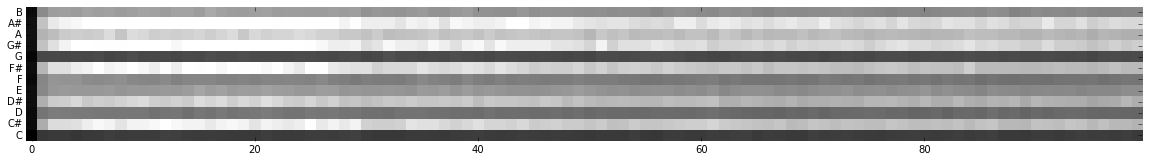

In [44]:
display_chroma(divide_pitches(reconstructions[0]), length=100)
!timidity ChromaMIDIs/reconstruction0.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction5.mid
MIDI file: ChromaMIDIs/reconstruction5.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
No pre-resampling cache hit
Playing time: ~3 seconds
Notes cut: 0
Notes lost totally: 0


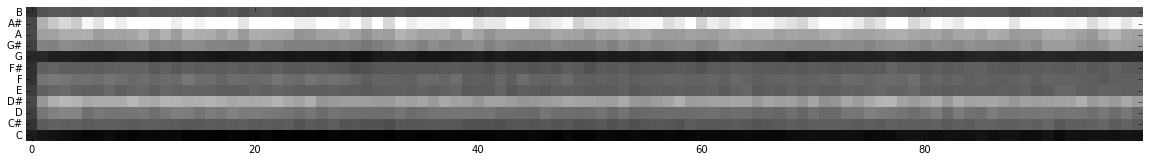

In [45]:
display_chroma(divide_pitches(reconstructions[1]), length=100)
!timidity ChromaMIDIs/reconstruction5.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction10.mid
MIDI file: ChromaMIDIs/reconstruction10.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



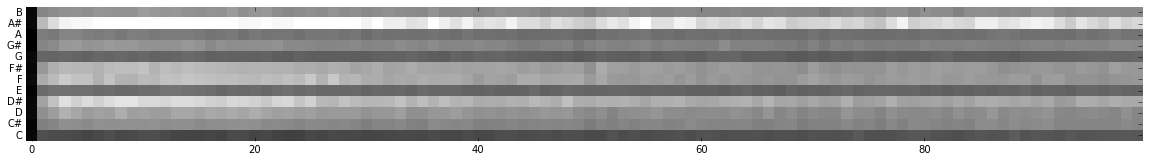

In [46]:
display_chroma(divide_pitches(reconstructions[2]), length=100)
!timidity ChromaMIDIs/reconstruction10.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction15.mid
MIDI file: ChromaMIDIs/reconstruction15.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



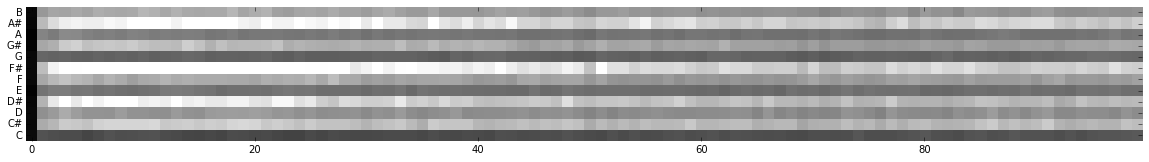

In [47]:
display_chroma(divide_pitches(reconstructions[3]), length=100)
!timidity ChromaMIDIs/reconstruction15.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction20.mid
MIDI file: ChromaMIDIs/reconstruction20.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



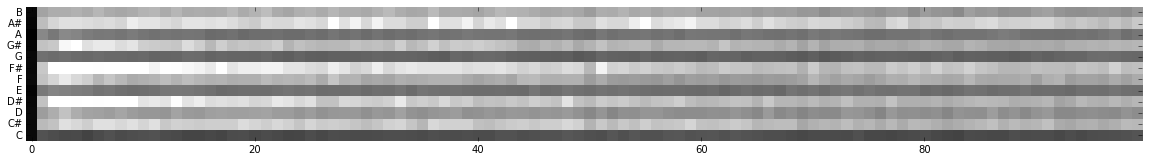

In [48]:
display_chroma(divide_pitches(reconstructions[4]), length=100)
!timidity ChromaMIDIs/reconstruction20.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction25.mid
MIDI file: ChromaMIDIs/reconstruction25.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



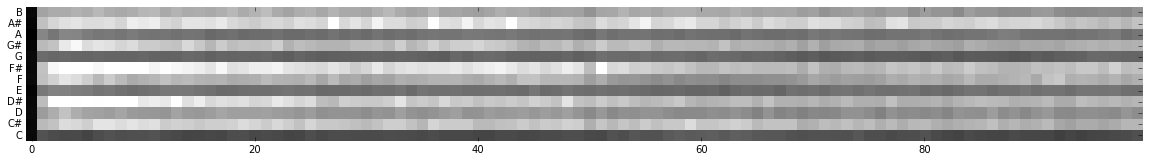

In [49]:
display_chroma(divide_pitches(reconstructions[5]), length=100)
!timidity ChromaMIDIs/reconstruction25.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction30.mid
MIDI file: ChromaMIDIs/reconstruction30.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



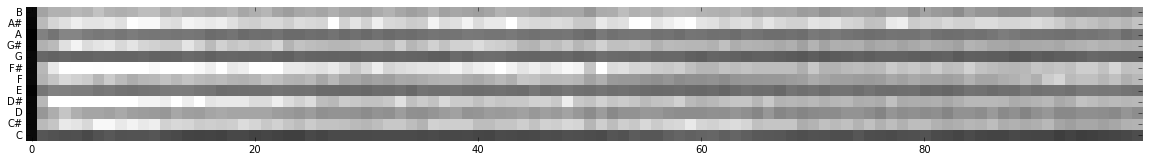

In [51]:
display_chroma(divide_pitches(reconstructions[6]), length=100)
!timidity ChromaMIDIs/reconstruction30.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction35.mid
MIDI file: ChromaMIDIs/reconstruction35.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



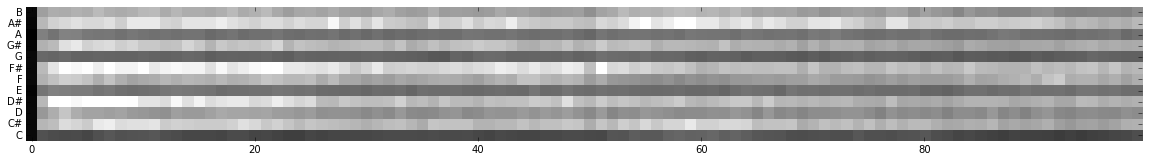

In [52]:
display_chroma(divide_pitches(reconstructions[7]), length=100)
!timidity ChromaMIDIs/reconstruction35.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction40.mid
MIDI file: ChromaMIDIs/reconstruction40.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



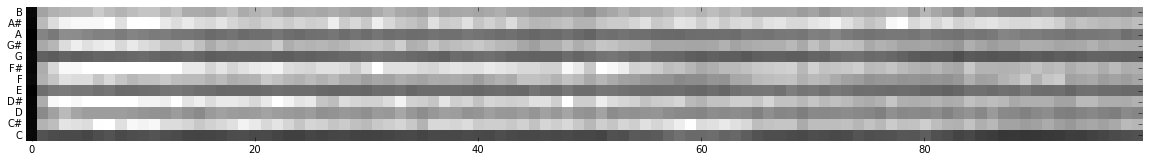

In [54]:
display_chroma(divide_pitches(reconstructions[8]), length=100)
!timidity ChromaMIDIs/reconstruction40.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/reconstruction45.mid
MIDI file: ChromaMIDIs/reconstruction45.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



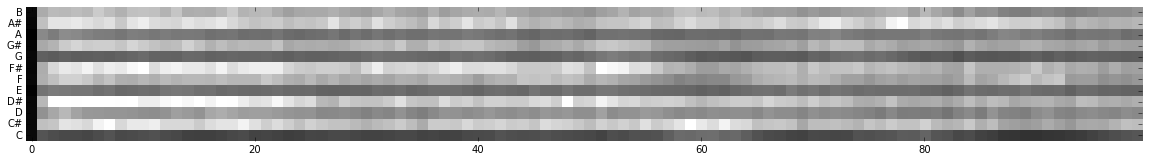

In [55]:
display_chroma(divide_pitches(reconstructions[9]), length=100)
!timidity ChromaMIDIs/reconstruction45.mid

Requested buffer size 32768, fragment size 8192
ALSA pcm 'default' set buffer size 32768, period size 8192 bytes
Playing ChromaMIDIs/original.mid
MIDI file: ChromaMIDIs/original.mid
Format: 1  Tracks: 1  Divisions: 960
Sequence: Main Track
^CTerminated sig=0x02



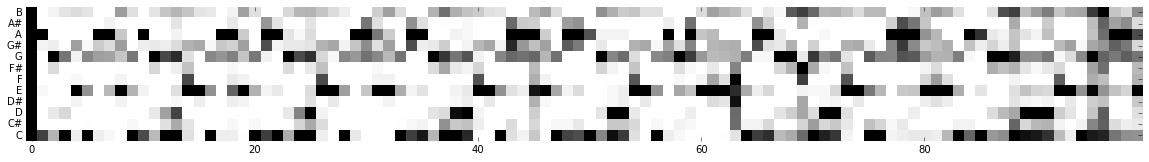

In [41]:
display_chroma(divide_pitches(specimen[1]), length=100)
!timidity ChromaMIDIs/original.mid

In [57]:
#Maybe next step: Clean up chroma features; e.g all chroma features consist of mostly zeros and up to four ones
def apply_threshold(pitches, num_to_keep):
    pitches_divided = []
    for i in range(len(pitches)/12):
        pitches_divided.append(pitches[i*12:(i+1)*12])
        
    thresholded_pitches = []
    for twelve in pitches_divided:
        if(num_to_keep == 0):
            indices_to_keep = []
        else:
            indices_to_keep = np.argsort(twelve)[-num_to_keep:]
        thresholded_twelve = []
        for i in range(12):
            if(i in indices_to_keep):
                thresholded_twelve.append(twelve[i])
            else:
                thresholded_twelve.append(0)
        thresholded_pitches.append(thresholded_twelve)
        
    flat_thresh = [pitch for twelve in thresholded_pitches for pitch in twelve]
       
    return np.array(flat_thresh)

In [58]:
apply_threshold([1,2,3,4,5,6,7,8,9,0,1,2,2,7,1,8,3,1,4,1,0,5,7,7],6)

array([0, 0, 0, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 7, 0, 8, 0, 0, 4, 0, 0, 5, 7,
       7])

In [59]:
print fullRDD.first()[1][:108]
threshfullRDD = fullRDD.map(lambda (k, chroma): (k, apply_threshold(chroma, 4)))
print threshfullRDD.first()[1][:108]

[ 0.814  1.     0.5    0.435  0.436  0.418  0.343  0.323  0.377  0.278
  0.326  0.16   1.     0.416  0.168  0.181  0.2    0.205  0.352  0.307
  0.121  0.094  0.474  0.066  1.     0.765  0.73   0.727  0.418  0.418
  0.531  0.531  0.514  0.517  0.735  0.723  1.     0.725  0.565  0.58
  0.496  0.476  0.563  0.558  0.652  0.647  0.495  0.069  1.     0.497
  0.378  0.407  0.517  0.493  0.699  0.712  0.613  0.62   0.302  0.051  1.
  0.692  0.25   0.166  0.186  0.103  0.115  0.092  0.079  0.056  0.087
  0.389  1.     0.43   0.054  0.109  0.163  0.125  0.075  0.061  0.053
  0.032  0.031  0.203  1.     0.801  0.118  0.144  0.143  0.095  0.071
  0.172  0.111  0.045  0.051  0.131  1.     0.275  0.125  0.13   0.622
  0.602  0.84   0.847  0.499  0.508  0.7    0.105]
[ 0.814  1.     0.5    0.     0.436  0.     0.     0.     0.     0.     0.
  0.     1.     0.416  0.     0.     0.     0.     0.352  0.     0.     0.
  0.474  0.     1.     0.765  0.73   0.     0.     0.     0.     0.     0.
  0.     0.

In [60]:
threshfullRDD.cache()
import time
start = time.time()
#top_components, song_scores, comp_eigvals = pca(fullRDD, k=3)
top_components, song_scores, comp_eigvals = pca(threshfullRDD, k=50)
print time.time() - start

321.406946898


In [61]:
#Amount, out of 1, of variance explained
for i in range(50):
    print sum(comp_eigvals[:i])/sum(comp_eigvals)

0.0
0.0319432294059
0.0594799384688
0.0822300105284
0.101178539483
0.115070470884
0.127947423953
0.13925912402
0.148977755762
0.155440080656
0.160726791744
0.165913458887
0.170807112274
0.175409543365
0.179901077809
0.184233766595
0.188270308756
0.192107703514
0.19547441621
0.198801056678
0.202060179261
0.205239802716
0.208340400012
0.211391643266
0.214397202285
0.217331429905
0.220207192701
0.223015396007
0.225810929759
0.228557210491
0.231240617084
0.233904605596
0.23652481332
0.239099099086
0.24165837845
0.244183309516
0.246671803686
0.249135084134
0.251573838544
0.25400736507
0.256422008991
0.258805350897
0.261173682913
0.263494537138
0.265782388317
0.268050956599
0.27029916086
0.272531544173
0.274738616251
0.276926857534


In [ ]:
#Maybe an autoencoder would do better